# Deep Learning &mdash; Assignment 10

Assignment for week 10 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a variational autoencoder
2. Extend the model to a conditional VAE

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [2]:
%config InlineBackend.figure_formats =['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

## 10.1 MNIST dataset (no points)

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divided over 10 classes.

**(a) Run the code below to load the MNIST dataset.**

In [3]:
opts = {'batch_size': 32, 'shuffle': True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    **opts)
num_classes = 10

## 10.2 Variational Autoencoder (VAE) (3 points)

We will implement a Variational Autoencoder. This model consists of two networks: an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

**(a) Complete the implementation below.<span style="float:right"> (2 points)</span>**

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 16), nn.ReLU()
        )
        self.encoder_mean = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7 * 7 * 64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: Choose an appropriate activation function for the final layer.
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        # TODO: turn the sample ε from N(0,1) into a sample from N(μ,σ)
        eps *= std_z
        eps += mean_z
        return eps

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1, 64, 7, 7))  # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

In [5]:
# Here are some unit tests for the VAE
samples = VAE().sample_latent(torch.ones(10000), torch.ones(10000))
assert F.mse_loss(torch.mean(samples), torch.tensor(1.)) < 1e-3, \
    'sample_latent should produce values with the specified mean'
assert F.mse_loss(torch.log(torch.var(samples)), torch.tensor(1.)) < 1e-3, \
    'sample_latent should produce values with the specified log variance'

The decoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for doing it this way. 

**(b) What can go wrong if the encoder network directly outputs mean and standard deviation (μ,σ)?<span style="float:right"> (1 point)</span>**

Because it's more numerically stable.

## 10.3 Loss function (2 points)

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = \log P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we can use [binary cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html) for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf). Be careful:
* the paper defines $-D_{KL}$, not $D_{KL}$
* the sum is only over the latent space. In our code this corresponds to `axis=1`. Use the mean over the samples in the batch (`axis=0`).

**(a) Implement the KL loss term below.<span style="float:right"> (2 points)</span>**

In [6]:
def reconstruction_loss(recon_x, x):
    # The reconstruction loss is binary cross entropy
    # Note: we normalize the loss wrt. the batch size (len(x)), but not the size of the image
    return F.binary_cross_entropy(recon_x, x, reduction='sum') / len(x)


def kl_loss(mean_z, logvar_z):
    # The KL divergence between a standard normal distribution and
    #  a normal distribution with given mean and log-variance.
    # TODO: your code here

    mean_z = torch.mean(mean_z, dim=0, dtype=float)
    logvar_z = torch.mean(logvar_z, dim=0, dtype=float)

    std_z = torch.exp(0.5 * logvar_z)
    return torch.sum(torch.log(std_z) + (1 + mean_z ** 2) / (2 * std_z ** 2) - 0.5)


def loss_function(recon_x, x, mean_z, logvar_z):
    l_recon = reconstruction_loss(recon_x, x)
    l_kl = kl_loss(mean_z, logvar_z)
    return l_recon + l_kl, l_recon, l_kl

In [7]:
# Here are some unit tests for the loss function
assert kl_loss(torch.tensor([[0]]), torch.tensor([[0]])) == 0, \
    'KL loss should be 0 for μ=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[-1]])) > 0, \
    'KL loss should be > 0 for μ=0, σ<1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) > 0, \
    'KL loss should be > 0 for μ=0, σ>1'
assert kl_loss(torch.tensor([[1]]), torch.tensor([[0]])) > 0, \
    'KL loss should be > 0 for μ!=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) == \
       kl_loss(torch.tensor([[0, 0]]), torch.tensor([[1, 1]])) / 2, \
    'Take the sum over the latent dimensions'
assert kl_loss(torch.tensor([[0, 0, 1]]), torch.tensor([[0, 1, -0.5]])) == \
       kl_loss(torch.tensor([[0, 0, 1], [0, 0, 1]]), torch.tensor([[0, 1, -0.5], [0, 1, -0.5]])), \
    'Take the mean over the items in the batch or normalize wrt. batch size (see also reconstruction_loss)'

## 10.4 Training our VAE (3 points)

**(a) Complete the training loop below<span style="float:right"> (2 points)</span>**

In [8]:
def train(model, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'train recon. loss', 'train KL loss',
                                    'test loss', 'test recon. loss', 'test KL loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mean_z, logvar_z = model.forward(x)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
            # TODO: compute the outputs and loss
            # TODO: backpropagate and apply optimizer
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_recon.detach(), loss_kl.detach(), x.shape[0])
        # Compute test loss
        test_loss, test_loss_recon, test_loss_kl = test(model)
        # Plot
        train_loss_recon = metric[0] / metric[2]
        train_loss_kl = metric[1] / metric[2]
        train_loss = train_loss_recon + train_loss_kl
        animator.add(epoch + 1,
                     (train_loss, train_loss_recon, train_loss_kl,
                      test_loss, test_loss_recon, test_loss_kl))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, test reconstruction loss {test_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iter):
            x = x.to(device)
            recon_x, mean_z, logvar_z = model.forward(x)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
            metric.add(loss_recon, loss_kl, x.shape[0])
    test_loss_recon = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_recon + test_loss_kl, test_loss_recon, test_loss_kl

**(b) Train the model.<span style="float:right"> (no points)</span>**

Hint: the training and test loss should both be around 5.

training loss 4.979, test loss 5.015
training reconstruction loss 4.898, test reconstruction loss 4.921
training KL loss 0.081, test KL loss 0.094


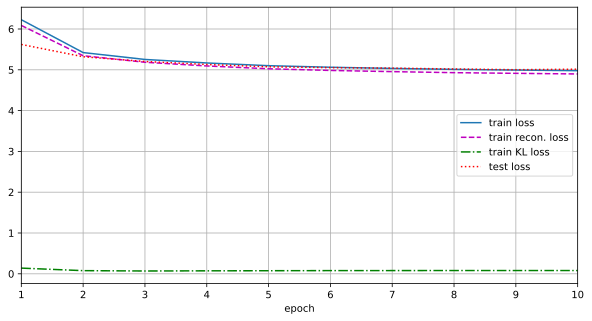

In [27]:
torch.manual_seed(12345)
device = d2l.try_gpu()
model = VAE().to(device)
train(model)

**(c) If you increase the number of latent dimensions, how does that affect the reconstruction loss and the KL loss terms?<span style="float:right"> (1 point)</span>**

training loss 4.938, test loss 4.926
training reconstruction loss 4.872, test reconstruction loss 4.857
training KL loss 0.066, test KL loss 0.069


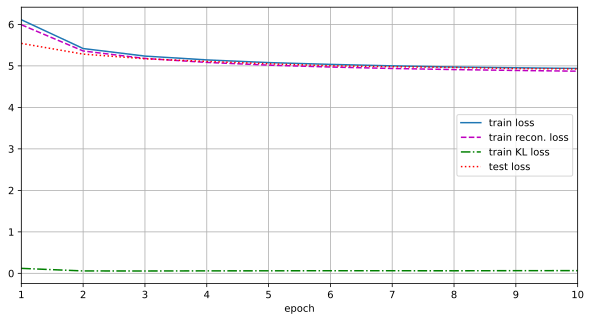

In [11]:
model = VAE(latent_size=10).to(device)
train(model)

training loss 4.506, test loss 4.508
training reconstruction loss 4.414, test reconstruction loss 4.420
training KL loss 0.092, test KL loss 0.088


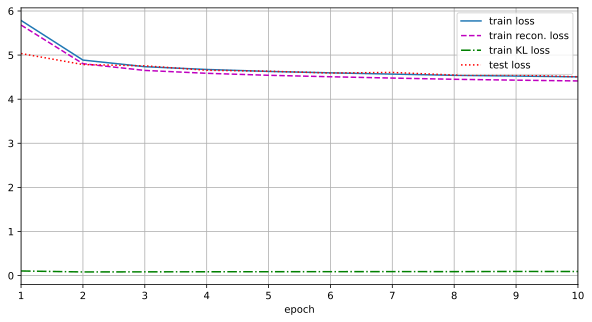

In [71]:
model = VAE(latent_size=5).to(device)
train(model)

| latent_size | training loss | test loss | training reconstruction loss | test reconstruction loss | training KL loss | test KL loss |
|-------------|---------------|-----------|------------------------------|--------------------------|------------------|--------------|
| 2           | 5.008         | 5.023     | 4.932                        | 4.940                    | 0.076            | 0.083        |
| 5           | 4.506         | 4.508     | 4.414                        | 4.420                    | 0.092            | 0.088        |
| 10          | 4.492         | 4.492     | 4.403                        | 4.409                    | 0.089            | 0.083        |

Increasing the latent size makes the reconstruction loss to go down slightly, and the KL loss does not significantly change.

## 10.5 Visualizing the latent space (8 points)

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.

**(a) Complete the code below and run it to plot the latent space.<span style="float:right"> (1 point)</span>**

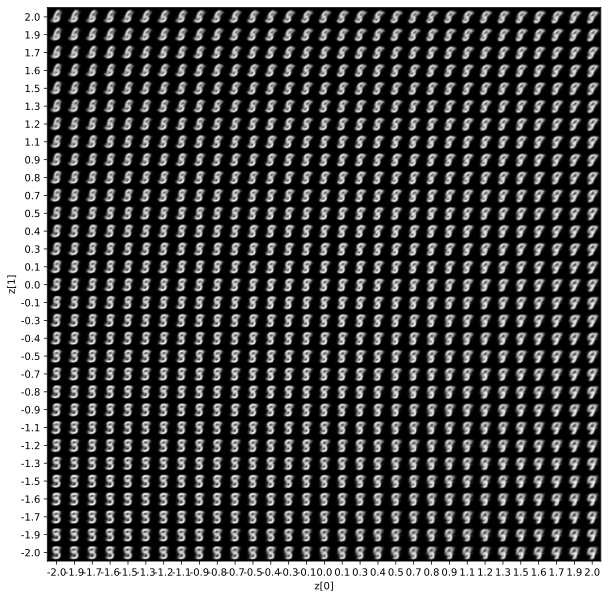

In [24]:
def plot_latent(model):
    # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            x_decoded = model.decode(z=torch.Tensor([xi, yi]).to(device))
            figure[
            i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(model)

**(b) Would it be possible to classify digits based on this latent representation? Explain your answer.<span style="float:right"> (1 point)</span>**

Yes, as a human, we can clearly identify most numbers, while some are ambiguous between two numbers. 

**(c) If you retrain the model, would you expect the latent space to look exactly the same. If not, what differences can you expect?<span style="float:right"> (1 point)</span>**

No, the latent space would change, because it is randomly initialized and therefore may use different representations for the same digits.

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.

**(d) Complete and run the code below to make a scatterplot of the training data.<span style="float:right"> (1 point)</span>**

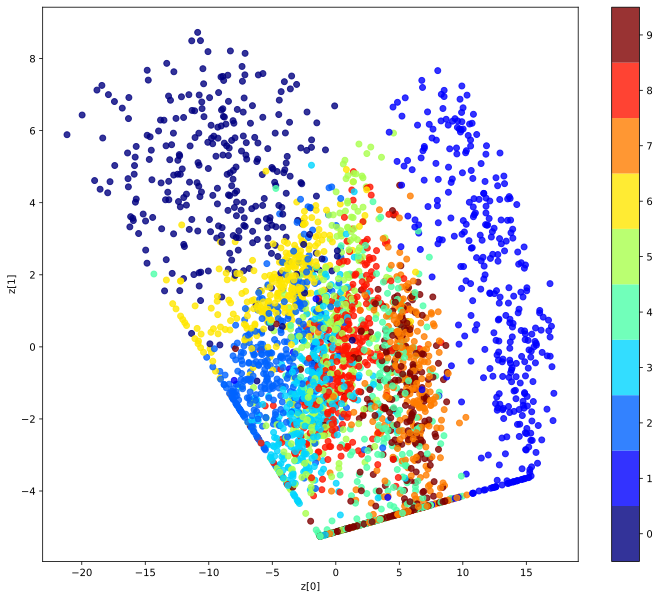

In [25]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for x, y in itertools.islice(train_iter, 100):
        z_mean, _ = model.encode(x.to(device))
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()

    cmap = plt.get_cmap('jet', 10)
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap=cmap, alpha=0.8, vmin=-0.5, vmax=9.5)
    plt.colorbar(ticks=np.arange(0, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


scatterplot_latent(model)

**(e) Compare this figure to the one from `plot_latent`. How are the plots related?<span style="float:right"> (1 point)</span>**

Note: Don't just answer "both visualize the latent space"

When looking at the same z[0], z[1] coordinates, we can clearly see that the model generates numbers that correspond to the numbers shown in the scatter plot.

**(f) Compared to the figure from `plot_latent`, what information about the VAE is shown in this figure but not in the previous one?<span style="float:right"> (1 point)</span>**

The second plot shows which part of the space is used most, i.e., the density in the latent space, and where the encoder is placing the different numbers. We can also see, how much space is between the individual data points, which is an indication of how clearly they are distinguished.

**(g) What distribution should we expect the points in the latent space to follow, based on the KL divergence term in the loss function?<span style="float:right"> (1 point)</span>**

We can expect some kind of normal distribution, as the KL divergence term punished based on the normal distribution.

**(h) Look at the distribution of the data in the latent space. Does the plot match the answer to the previous question? If not, why?<span style="float:right"> (1 point)</span>**

Yes, we can see that the different numbers are distributed in an ellipse, with more values in the middle than on the edge.

## 10.6 Conditional Variational Autoencoder (10 points)

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this *conditional VAE*, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice, this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z \cdot z + W_y \cdot y + b$.

Similarly for the encoder, except there we will still use a convolutional layer for $x$, combined with a fully connected layer for $y$.

**(a) Complete the implementation of the conditional VAE below.<span style="float:right"> (3 points)</span>**

In [73]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # TODO: split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input
        self.encoder_part1_x = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2)
        self.encoder_part1_y = nn.Linear(num_classes, 32 * 14 * 14)
        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 16), nn.ReLU()
        )
        self.encoder_mean = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7 * 7 * 64)
        # TODO: add layer to use with the y input
        self.decoder_part1_y = nn.Linear(num_classes, 7 * 7 * 64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: see VAE
            nn.Sigmoid()
        )

    def encode(self, x, y):
        y = nn.functional.one_hot(y, num_classes).float()
        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1, 32, 14, 14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        # TODO: see VAE
        eps *= std_z
        eps += mean_z
        return eps

    def decode(self, z, y):
        # TODO: use a first layer that combines z and y
        y = nn.functional.one_hot(y, num_classes).float()
        h_z = self.decoder_part1_z(z)
        h_y = self.decoder_part1_y(y)
        h = h_y + h_z
        h = torch.reshape(h, (-1, 64, 7, 7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

**(b) Copy the training code from section 10.4, and modify it for a conditional VAE.<span style="float:right"> (1 point)</span>**

Hint: To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [29]:
def train_cvae(model, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'train recon. loss', 'train KL loss',
                                    'test loss', 'test recon. loss', 'test KL loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            recon_x, mean_z, logvar_z = model.forward(x, y)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
            # TODO: compute the outputs and loss
            # TODO: backpropagate and apply optimizer
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_recon.detach(), loss_kl.detach(), x.shape[0])
        # Compute test loss
        test_loss, test_loss_recon, test_loss_kl = test_cvae(model)
        # Plot
        train_loss_recon = metric[0] / metric[2]
        train_loss_kl = metric[1] / metric[2]
        train_loss = train_loss_recon + train_loss_kl
        animator.add(epoch + 1,
                     (train_loss, train_loss_recon, train_loss_kl,
                      test_loss, test_loss_recon, test_loss_kl))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, test reconstruction loss {test_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')

# TODO: your code here

def test_cvae(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iter):
            x = x.to(device)
            y = y.to(device)
            recon_x, mean_z, logvar_z = model.forward(x, y)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
            metric.add(loss_recon, loss_kl, x.shape[0])
    test_loss_recon = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_recon + test_loss_kl, test_loss_recon, test_loss_kl

# TODO: your code here

**(c) Train a conditional VAE**

training loss 4.089, test loss 4.113
training reconstruction loss 4.039, test reconstruction loss 4.070
training KL loss 0.050, test KL loss 0.043


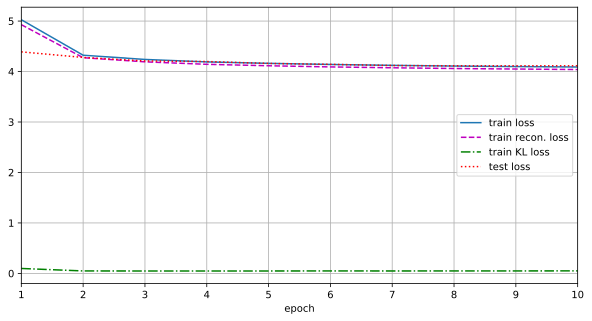

In [74]:
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model)

**(d) Adapt the `plot_latent` function from section 10.5 for conditional VAEs, and use your function to visualize the latent space for the classes `4` and `8`.<span style="float:right"> (1 point)</span>**

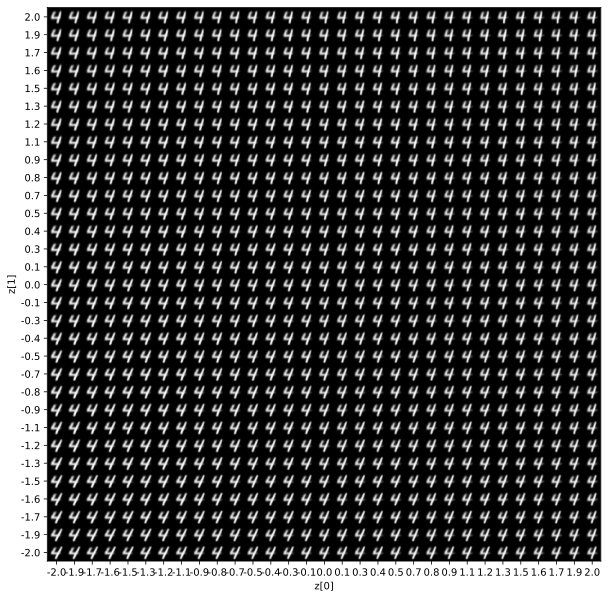

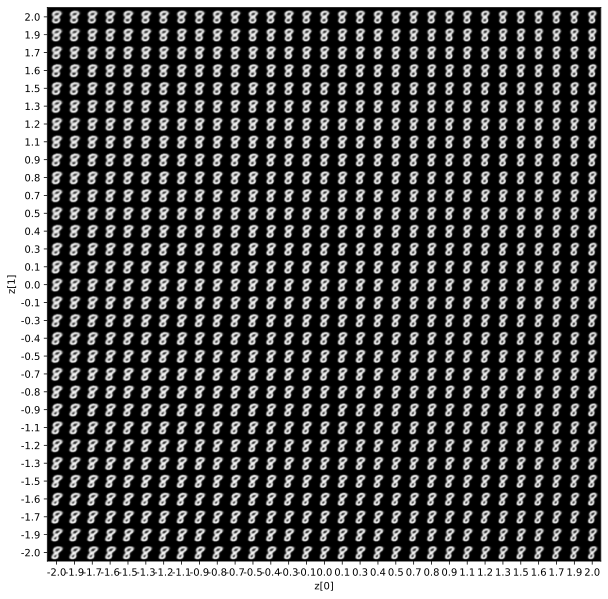

In [79]:
def plot_latent_cvae(model, ys):
    # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for y in ys:
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                # TODO: run the decoder on z = [xi,yi].
                x_decoded = model.decode(torch.Tensor([xi, yi]).to(device), torch.tensor([y]).to(device))
                figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size,
                ] = x_decoded.detach().cpu().numpy()

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap="Greys_r")
        plt.show()


plot_latent_cvae(cvae_model, [4, 8])

**(e) What do the latent dimensions represent? Is this the same for all labels?<span style="float:right"> (1 point)</span>**

The latent dimensions seem to represent the small variations on how exactly the numbers are written. The latent dimensions seem to represent the same variation in style even for different labels, which is probably caused by sharing big parts of the network.

**(f) Adapt `scatterplot_latent` to show the distribution in the latent space.<span style="float:right"> (1 point)</span>**

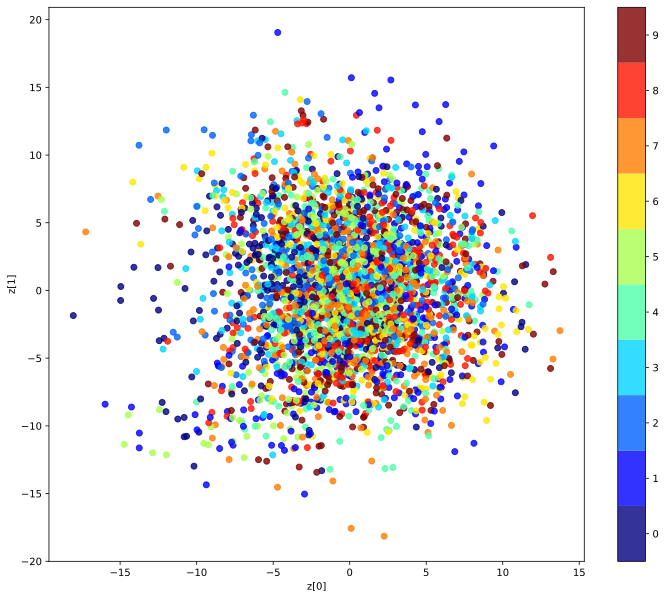

In [82]:
def scatterplot_latent_cvae(cvae_model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for x, y in itertools.islice(train_iter, 100):
        z_mean, _ = cvae_model.encode(x.to(device), y.to(device))
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()

    cmap = plt.get_cmap('jet', 10)
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap=cmap, alpha=0.8, vmin=-0.5, vmax=9.5)
    plt.colorbar(ticks=np.arange(0, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


scatterplot_latent_cvae(cvae_model)

**(g) How is this distribution in the latent space different from the distribution of the VAE? Compare to your answer to that for question 10.5 g and h. What is the cause of these differences?<span style="float:right"> (1 point)</span>**

The latent space is no longer divided into clusters per digit. This is because it's not needed anymore, because of the digit in known to the encoder and decoder. Therefore, they do not have to distinguish them anymore themselves.

**(h) Would it be possible to classify digits based on the latent representation of the conditional VAE? Explain your answer.<span style="float:right"> (1 point)</span>**

No, because the representation of the different digits in the latent space is not seperable anymore.

**(i) Describe how you could use a conditional VAE to change the label or content of an image, while keeping the style as similar as possible.<span style="float:right"> (1 point)</span>**

You would encode a digit with the style that you want and the current label and use its latent representation with a different, i.e., the target label, to decode it to a different digit with the same style.

## 10.7 Discussion (2 points)

**(a) Is the conditional VAE a strict improvement over the normal VAE in all cases?<span style="float:right"> (1 point)</span>**

No, because they are designed for different use cases. The VAE can be used to detect a number, while the other needs to know the label in advance, for example.

**(b) Compare the latent representation vector $z$ in the VAE with the input for the generator in a GAN. They are both small vectors, and they are both often called $z$. In what way are they the same, and in what way are the different?<span class="float:right"> (1 point)</span>**

In both cases z represents the input to the generator, but in the GAN case, it's just random noise, while in the VAE case it is encoded from a real sample. This means that VAEs can keep the semantics while GANs cannot.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 28 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 7536f1e / 2023-11-15</span>